# Naural Networks

## Załadowanie i przygotowanie danych

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Wstępne załadowanie i eskploracja oryginalnych danych.

In [103]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:9999, :]
chess.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Zakodowanie godzin na dane z zakresu (0, 1)

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [104]:
hoursAfterMidnight = (chess.loc[:, 'created_at']/1000).apply(datetime.fromtimestamp).dt.hour
chess['sin_created_at'] = np.sin(2*np.pi*hoursAfterMidnight/24)
chess['cos_created_at'] = np.cos(2*np.pi*hoursAfterMidnight/24)

In [105]:
hoursAfterMidnight

0       22
1       23
2       23
3       18
4       20
        ..
9995    14
9996    12
9997    10
9998    10
9999     9
Name: created_at, Length: 10000, dtype: int64

Usunięcie niepotrzebnych kolumn.

In [106]:
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'moves', 'black_id', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply,sin_created_at,cos_created_at
0,False,13,white,15+2,1500,1191,D10,5,-0.500000,8.660254e-01
1,True,16,black,5+10,1322,1261,B00,4,-0.258819,9.659258e-01
2,True,61,white,5+10,1496,1500,C20,3,-0.258819,9.659258e-01
3,True,61,white,20+0,1439,1454,D02,3,-1.000000,-1.836970e-16
4,True,95,white,30+3,1523,1469,C41,5,-0.866025,5.000000e-01


Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

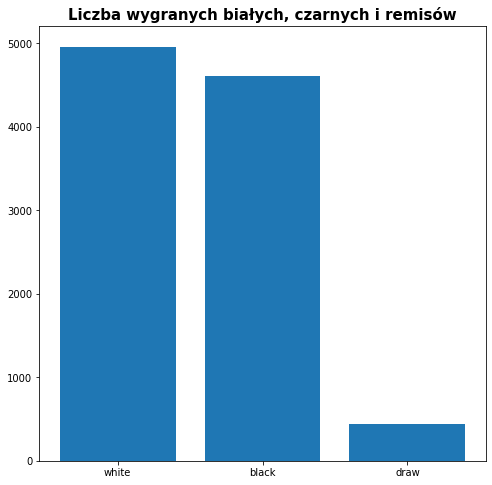

In [107]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Zamiana kolumny rated z Boolen na zero-jedynkową i zakodowanie wartości kategorycznych

In [108]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1
yRaw = chess.loc[:, 'winner']
temp = pd.get_dummies(chess.loc[:, ['increment_code', 'winner', 'opening_eco']])
chess.drop(columns=['increment_code', 'winner', 'opening_eco'], inplace=True)
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-5.000000e-01,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000e+00,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-8.660254e-01,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,63,1195,1369,5,-5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,95,1195,1369,3,1.224647e-16,-1.000000e+00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,76,1195,1247,6,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,1,40,1369,1062,4,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
chess.head()

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-0.500000,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-0.866025,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą, oraz podział na zbiór uczący i testowy w stosunku 80/20

In [55]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = chess.loc[:, ['winner_black',	'winner_draw', 'winner_white']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

Dense Layer: https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/

Cross_entropy: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy

In [12]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

2022-05-28 12:05:43.109401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [13]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

Fitowanie modelu

In [14]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 0s 6ms/step - loss: 66.0049 - categorical_accuracy: 0.1326
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 28.4187 - categorical_accuracy: 0.4946
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 5.7906 - categorical_accuracy: 0.2849
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 2.2711 - categorical_accuracy: 0.5236
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 2.0470 - categorical_accuracy: 0.5651
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 1.8256 - categorical_accuracy: 0.5869
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 1.6370 - categorical_accuracy: 0.5851
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 1.4008 - categorical_accuracy: 0.5890
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 1.1183 - categorical_accuracy: 0.6000
Epoch 10/100
8/8

Przedstawienie accuracy dla kazdego ze 100 epchów na wykresie liniowym

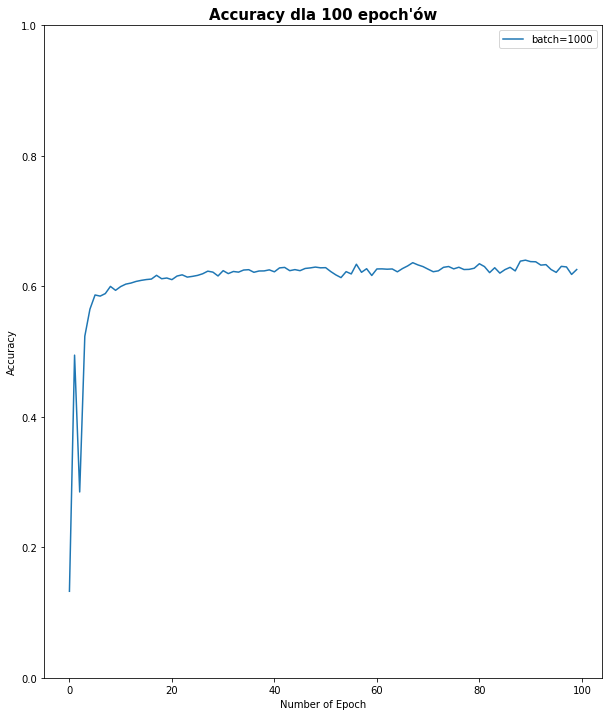

In [15]:
plt.figure(figsize=(10, 12))
plt.title("Accuracy dla 100 epoch'ów", fontdict={"fontweight": "bold", "size": 15})
plt.ylabel("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylim(0, 1)
plt.plot(batch1000.history['categorical_accuracy'], label="batch=1000")
plt.legend()

Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Funkcja straty: https://www.brutalk.com/pl/wiadomosci/brutalk-blog/przeglad/funkcje-strat-i-strat-do-szkolenia-sieci-neuronowych-uczenia-glebokiego-6046fa42120e8

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

Categorical accuracy: https://towardsdatascience.com/keras-accuracy-metrics-8572eb479ec7

### model evaluation

In [16]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.7589 - categorical_accuracy: 0.6235


[0.758875846862793, 0.6234999895095825]

## Próba przewidzenie czy wygra biały


In [17]:
yWhite = y.loc[:, 'winner_white']
X_train, X_test, y_train, y_test = train_test_split(X, yWhite, test_size=0.2)

In [18]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='softmax'))

In [19]:
opt = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

In [20]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 0s 5ms/step - loss: 7.7187 - binary_accuracy: 0.4947
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1223 - binary_accuracy: 0.4947
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 1.8567 - binary_accuracy: 0.4947
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 1.3836 - binary_accuracy: 0.4947
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 1.2502 - binary_accuracy: 0.4947
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 1.0885 - binary_accuracy: 0.4947
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 1.0017 - binary_accuracy: 0.4947
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9352 - binary_accuracy: 0.4947
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8858 - binary_accuracy: 0.4947
Epoch 10/100
8/8 [==============================] - 0s 7ms/step 

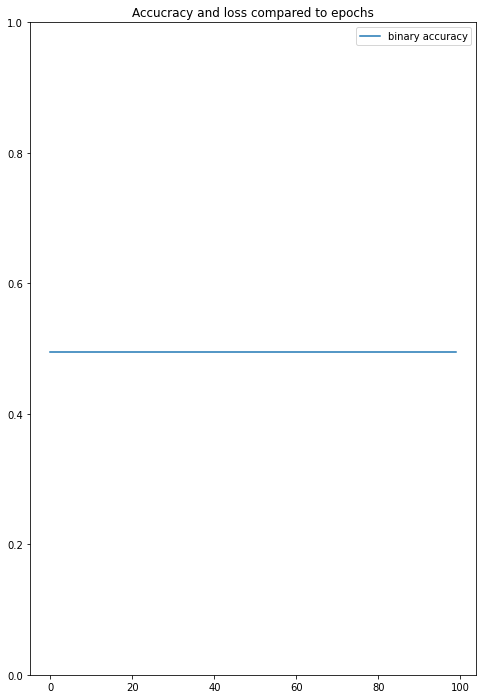

In [21]:
plt.figure(figsize=(8,12))
# plt.plot(batch1000.history['loss'], label="loss")
plt.plot(batch1000.history['binary_accuracy'], label="binary accuracy")
plt.title("Accucracy and loss compared to epochs")
plt.ylim(0, 1)
plt.legend()

In [22]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.6561 - binary_accuracy: 0.5010


[0.656141996383667, 0.5009999871253967]

Wynik gorszy od początkowego modelu

## Skuteczność modelu w zależności od liczby warstw neuronów i zmian hiperparametrów

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [124]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = yRaw.replace({"white": 0, "black": 1, "draw": 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [129]:
y_train.shape

(8000,)

In [142]:
def build_clf(unit):
    model = Sequential()
    model.add(Dense(units=unit, input_dim=634, activation='relu'))
    model.add(Dense(units=unit, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [148]:
model = KerasClassifier(build_fn=build_clf)

params= {"epochs": list(range(20, 120, 40)), 
        "batch_size": [100, 500, 1000, 2000],
        "unit": [8, 16]}
# f1 = make_scorer(accuracy_score)

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

/var/folders/6v/9h3mqcyj2ylfrpgzflt3jn2r0000gn/T/ipykernel_49369/3065279902.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [149]:
grid_result = grid.fit(X_train, y_train)

2022-05-28 13:47:30.124705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 13:47:30.126894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 13:47:30.127020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
64/64 [==============================] - 2s 8ms/step - loss: 8.2555 - accuracy: 0.4577
Epoch 2/20
64/64 [==============================] - 2s 8ms/step - loss: 11.1759 - accuracy: 0.3811
Epoch 2/20
64/64 [==============================] - 2s 9ms/step - loss: 8.5036 - accuracy: 0.4686
Epoch 2/20
64/64 [==============================] - 2s 5ms/step - loss: 1.7046 - accuracy: 0.4652
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 1.1569 - accuracy: 0.5980
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 1.1020 - accuracy: 0.5536
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 1.0637 - accuracy: 0.4950
Epoch 3/20
64/64 [==============================] - 0s 6ms/step - loss: 1.0874 - accuracy: 0.4552
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0081 - accuracy: 0.6064
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.9451 - acc

13/13 [==============================] - 0s 5ms/step - loss: 0.7532 - accuracy: 0.6323
Epoch 74/100
13/13 [==============================] - 0s 5ms/step - loss: 0.7727 - accuracy: 0.6195
Epoch 87/100
13/13 [==============================] - 0s 16ms/step - loss: 0.7596 - accuracy: 0.6278
Epoch 75/100
13/13 [==============================] - 1s 6ms/step - loss: 0.7693 - accuracy: 0.6170
Epoch 89/100
Epoch 76/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7479 - accuracy: 0.6411
Epoch 77/100
Epoch 90/100
13/13 [==============================] - 0s 5ms/step - loss: 0.7501 - accuracy: 0.6452
Epoch 91/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7515 - accuracy: 0.6356
Epoch 78/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7517 - accuracy: 0.6406
Epoch 92/100
Epoch 79/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7467 - accuracy: 0.6461
Epoch 93/100
13/13 [==============================] - 0s 7ms/step - loss

======] - 0s 13ms/step - loss: 1.5451 - accuracy: 0.4900
Epoch 6/20
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 4.3024 - accuracy: 0.4350
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 4.2297 - accuracy: 0.4464
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 2.8043 - accuracy: 0.4130
Epoch 8/20
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 1.0850 - accuracy: 0.4980
Epoch 9/20
7/7 [==============================] - 0s 9ms/step - loss: 1.7750 - accuracy: 0.3425
Epoch 8/20
7/7 [==============================] - 0s 6ms/step - loss: 1.0829 - accuracy: 0.4980
Epoch 10/20
7/7 [==============================] - 0s 6ms/step - loss: 1.8839 - accuracy: 0.4212
Epoch 9/20
7/7 [==============================] - 0s 6ms/step - loss: 1.0810 - accuracy: 0.4980
Epoch 11/20
7/7 [==============================] - 0s 7ms/step - loss: 1.6677 - accuracy: 0.3500
Epoch 10/20
7/7 [==============================] - 0s 

630
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 1.0279 - accuracy: 0.5914
Epoch 8/20
7/7 [==============================] - 0s 6ms/step - loss: 0.9470 - accuracy: 0.6017
Epoch 9/20
7/7 [==============================] - 0s 6ms/step - loss: 0.8909 - accuracy: 0.6053
Epoch 10/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8587 - accuracy: 0.6117
Epoch 11/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8314 - accuracy: 0.6106
Epoch 12/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8119 - accuracy: 0.6147
Epoch 13/20
7/7 [==============================] - 0s 7ms/step - loss: 0.7995 - accuracy: 0.6211
Epoch 14/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7911 - accuracy: 0.6178
Epoch 15/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7848 - accuracy: 0.6184
Epoch 16/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7785 - accuracy: 0.6231
Epoch 17/20
7/7 [============

 [==============================] - 0s 5ms/step - loss: 2.7750 - accuracy: 0.3356
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 1.5613 - accuracy: 0.4105
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 1.4302 - accuracy: 0.4723
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 1.3194 - accuracy: 0.5102
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 1.2302 - accuracy: 0.5319
Epoch 8/20
7/7 [==============================] - 0s 9ms/step - loss: 1.1737 - accuracy: 0.5422
Epoch 9/20
7/7 [==============================] - 0s 6ms/step - loss: 1.1152 - accuracy: 0.5562
Epoch 10/20
7/7 [==============================] - 0s 6ms/step - loss: 1.0533 - accuracy: 0.5656
Epoch 11/20
7/7 [==============================] - 0s 6ms/step - loss: 0.9969 - accuracy: 0.5809
Epoch 12/20
7/7 [==============================] - 0s 6ms/step - loss: 0.9522 - accuracy: 0.5792
Epoch 13/20
7/7 [==============================] - 

7/7 [==============================] - 0s 6ms/step - loss: 0.7790 - accuracy: 0.6283
Epoch 45/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7786 - accuracy: 0.6308
Epoch 46/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7774 - accuracy: 0.6269
Epoch 47/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7775 - accuracy: 0.6241
Epoch 48/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7810 - accuracy: 0.6234
Epoch 49/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7771 - accuracy: 0.6288
Epoch 50/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7728 - accuracy: 0.6291
Epoch 51/60
7/7 [==============================] - 0s 9ms/step - loss: 0.7782 - accuracy: 0.6241
Epoch 52/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7748 - accuracy: 0.6263
Epoch 53/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7697 - accuracy: 0.6308
Epoch 54/60
7/7 [=========================

7/7 [==============================] - 0s 6ms/step - loss: 0.8214 - accuracy: 0.5362
Epoch 27/60
7/7 [==============================] - 0s 6ms/step - loss: 0.8198 - accuracy: 0.5402
Epoch 28/60
7/7 [==============================] - 0s 5ms/step - loss: 0.8176 - accuracy: 0.5605
Epoch 29/60
7/7 [==============================] - 0s 6ms/step - loss: 0.8159 - accuracy: 0.5730
Epoch 30/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8136 - accuracy: 0.5977
Epoch 31/60
7/7 [==============================] - 0s 6ms/step - loss: 0.8142 - accuracy: 0.6009
Epoch 32/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8140 - accuracy: 0.5994
Epoch 33/60
7/7 [==============================] - 0s 6ms/step - loss: 0.8102 - accuracy: 0.6056
Epoch 34/60
7/7 [==============================] - 0s 6ms/step - loss: 0.8135 - accuracy: 0.6106
Epoch 35/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8060 - accuracy: 0.6106
Epoch 36/60
7/7 [=========================

7/7 [==============================] - 0s 9ms/step - loss: 0.7768 - accuracy: 0.6233
Epoch 59/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8829 - accuracy: 0.6125
Epoch 23/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7738 - accuracy: 0.6191
Epoch 60/100
7/7 [==============================] - 0s 13ms/step - loss: 0.8713 - accuracy: 0.6161
Epoch 24/100
7/7 [==============================] - 0s 16ms/step - loss: 0.8630 - accuracy: 0.6217
Epoch 61/100
Epoch 25/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7751 - accuracy: 0.6197
Epoch 62/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8556 - accuracy: 0.6241
Epoch 26/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7832 - accuracy: 0.6077
Epoch 63/100
7/7 [==============================] - 0s 10ms/step - loss: 0.8506 - accuracy: 0.6212
Epoch 27/100
7/7 [==============================] - 0s 6ms/step - loss: 0.7745 - accuracy: 0.6197
Epoch 64/100


7/7 [==============================] - 0s 10ms/step - loss: 1.3303 - accuracy: 0.3389
Epoch 10/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9703 - accuracy: 0.4930
Epoch 57/100
7/7 [==============================] - 0s 11ms/step - loss: 1.2735 - accuracy: 0.3438
Epoch 11/100
7/7 [==============================] - 0s 13ms/step - loss: 0.9689 - accuracy: 0.4928
Epoch 58/100
7/7 [==============================] - 0s 9ms/step - loss: 1.2312 - accuracy: 0.3391
Epoch 12/100
7/7 [==============================] - 0s 8ms/step - loss: 0.9674 - accuracy: 0.4925
Epoch 59/100
7/7 [==============================] - 0s 9ms/step - loss: 1.1877 - accuracy: 0.3419
Epoch 13/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9660 - accuracy: 0.4925
Epoch 60/100
7/7 [==============================] - 0s 8ms/step - loss: 0.9645 - accuracy: 0.4925
Epoch 14/100
Epoch 61/100
7/7 [==============================] - 0s 17ms/step - loss: 1.1105 - accuracy: 0.3408
Epoch 15/100
7/

In [147]:
pd.DataFrame(grid_result.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_unit,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,6.604419,1.484302,1.146819,0.446974,1000,60,8,"{'batch_size': 1000, 'epochs': 60, 'unit': 8}",0.619375,0.604375,0.612500,0.628125,0.606875,0.614250,0.008646,1
0,6.468338,0.159391,0.689224,0.147132,100,20,8,"{'batch_size': 100, 'epochs': 20, 'unit': 8}",0.636250,0.605625,0.588125,0.621250,0.619375,0.614125,0.016224,2
11,14.848223,5.832843,0.830377,0.374133,500,100,16,"{'batch_size': 500, 'epochs': 100, 'unit': 16}",0.615000,0.596875,0.605000,0.633750,0.615625,0.613250,0.012371,3
9,8.669534,1.413328,0.884854,0.132791,500,60,16,"{'batch_size': 500, 'epochs': 60, 'unit': 16}",0.624375,0.582500,0.601875,0.630625,0.620625,0.612000,0.017591,4
16,16.013951,3.739375,1.511432,0.473161,1000,100,8,"{'batch_size': 1000, 'epochs': 100, 'unit': 8}",0.625000,0.600000,0.613125,0.616875,0.594375,0.609875,0.011190,5
15,9.123070,1.309349,1.262756,0.395866,1000,60,16,"{'batch_size': 1000, 'epochs': 60, 'unit': 16}",0.586250,0.600000,0.601250,0.635625,0.622500,0.609125,0.017605,6
21,8.053169,0.918638,1.604843,0.867071,2000,60,16,"{'batch_size': 2000, 'epochs': 60, 'unit': 16}",0.620625,0.575000,0.613750,0.607500,0.621875,0.607750,0.017169,7
7,3.397174,0.153497,0.770518,0.217045,500,20,16,"{'batch_size': 500, 'epochs': 20, 'unit': 16}",0.578750,0.605000,0.592500,0.629375,0.624375,0.606000,0.019025,8
22,16.493957,5.704393,1.460436,0.643394,2000,100,8,"{'batch_size': 2000, 'epochs': 100, 'unit': 8}",0.630625,0.599375,0.590625,0.608750,0.600625,0.606000,0.013588,8
23,16.972932,5.325009,0.733974,0.430169,2000,100,16,"{'batch_size': 2000, 'epochs': 100, 'unit': 16}",0.636250,0.608750,0.600625,0.638750,0.540000,0.604875,0.035704,10


Pressenting results (for binary classification): https://towardsdatascience.com/top-5-metrics-for-evaluating-classification-model-83ede24c7584